In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df_onshr_wind = pd.read_csv(f"scenario_data_agg/windonshore.csv")
df_load = pd.read_csv(f"scenario_data_agg/electricload.csv")
df_solar = pd.read_csv(f"scenario_data_agg/solar.csv")
df_offshr_wind = pd.read_csv(f"scenario_data_agg/windoffshore.csv")
df_hydro_ror = pd.read_csv(f"scenario_data_agg/hydroror.csv")
df_hydro_seasonal = pd.read_csv(f"scenario_data_agg/hydroseasonal.csv")

MAPPING = dict({
    "onshore_wind": df_onshr_wind,
    "load": df_load,
    "solar": df_solar,
    "offshore_wind": df_offshr_wind,
    "hydro_ror": df_hydro_ror,
    "hydro_seasonal": df_hydro_seasonal
})

def remove_time_and_filter_location(df: pd.DataFrame, location: str) -> pd.DataFrame:
    _df = df.copy()
    _df = _df.drop(columns=["time"])
    _df = _df[[location]]
    return _df

def _calculate_rank_values(df: pd.DataFrame, sampling_hours: list[int] = None) -> pd.DataFrame:
    _df = df.copy()
    if sampling_hours != None:
        _df = _df.filter(items=sampling_hours, axis=0)

    _df["rank"] = _df.rank(method="first")
    # Sample and reindex to get random order if tie
    #_df["rank"] = _df.sample(frac=1).rank(method='first').reindex_like(_df)
    _df["rank_value"] = _df["rank"] / len(_df)
    return _df

def generate_copula_2d(df_x: pd.DataFrame, df_y: pd.DataFrame, sampling_hours: list[int] | None = None) -> pd.DataFrame:
    _df_x = _calculate_rank_values(df_x, sampling_hours)
    _df_y = _calculate_rank_values(df_y, sampling_hours)
    df_copula = pd.DataFrame(index=range(0, len(_df_x)) if sampling_hours == None else sampling_hours)
    df_copula["rank_value_x"] = df_copula.join(_df_x)[["rank_value"]]
    df_copula["rank_value_y"] = df_copula.join(_df_y)[["rank_value"]]
    return df_copula

def generate_copula_3d(df_x: pd.DataFrame, df_y: pd.DataFrame, df_z: pd.DataFrame, sampling_hours: list[int] | None = None) -> pd.DataFrame:
    _df_x = _calculate_rank_values(df_x, sampling_hours)
    _df_y = _calculate_rank_values(df_y, sampling_hours)
    _df_z = _calculate_rank_values(df_z, sampling_hours)
    df_copula = pd.DataFrame(index=range(0, len(_df_x)) if sampling_hours == None else sampling_hours)
    df_copula["rank_value_x"] = df_copula.join(_df_x)[["rank_value"]]
    df_copula["rank_value_y"] = df_copula.join(_df_y)[["rank_value"]]
    df_copula["rank_value_z"] = df_copula.join(_df_z)[["rank_value"]]
    return df_copula

### 3D-clustering

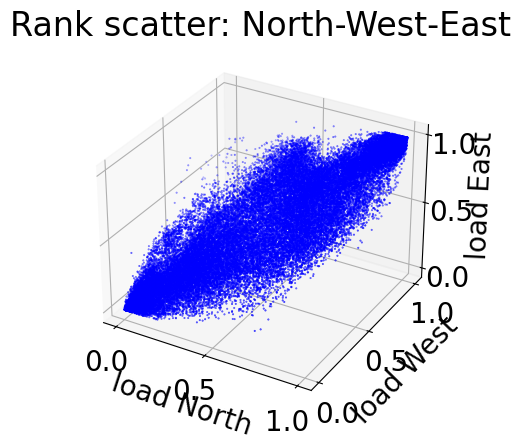

,rank_value_x,rank_value_y,rank_value_z
0,0.252031,0.495391,0.169131
1,0.231631,0.428897,0.114321
2,0.171299,0.334839,0.075347
3,0.149872,0.275260,0.067725
4,0.142228,0.257827,0.073795
...,...,...,...
43819,0.718898,0.627578,0.384150
43820,0.651721,0.502715,0.309351
43821,0.555312,0.459337,0.277040
43822,0.398275,0.446901,0.218488


In [11]:
LOCATION_X = "North"
LOCATION_Y = "West"
LOCATION_Z = "East"
DF_X = "load"
DF_Y = "load"
DF_Z = "load"

def plot_copula_3d(df: pd.DataFrame, loc_x: str, loc_y: str, loc_z: str) -> None:
    _df = df.copy()
    x = _df["rank_value_x"]
    y = _df["rank_value_y"]
    z = _df["rank_value_z"]

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z, color="blue", s=0.2)
    ax.set_xlabel(f"{DF_X} {loc_x}")
    ax.set_ylabel(f"{DF_Y} {loc_y}")
    ax.set_zlabel(f"{DF_Z} {loc_z}")
    ax.set_title(f"Rank scatter: {loc_x}-{loc_y}-{loc_z}")
    plt.show()

loc_x = LOCATION_X
loc_y = LOCATION_Y
loc_z = LOCATION_Z
df_x = remove_time_and_filter_location(MAPPING[DF_X], location=loc_x)
df_y = remove_time_and_filter_location(MAPPING[DF_Y], location=loc_y)
df_z = remove_time_and_filter_location(MAPPING[DF_Z], location=loc_z)


df_copula_original = generate_copula_3d(df_x, df_y, df_z, sampling_hours=None)
plot_copula_3d(df_copula_original, loc_x, loc_y, loc_z)
df_copula_original

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_51888/1484788119.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks, verticalalignment='baseline', horizontalalignment='left')
/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_51888/1484788119.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ticks, verticalalignment='baseline', horizontalalignment='left')
/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_51888/1484788119.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(ticks, verticalalignment='baseline', horizontalalignment='left')


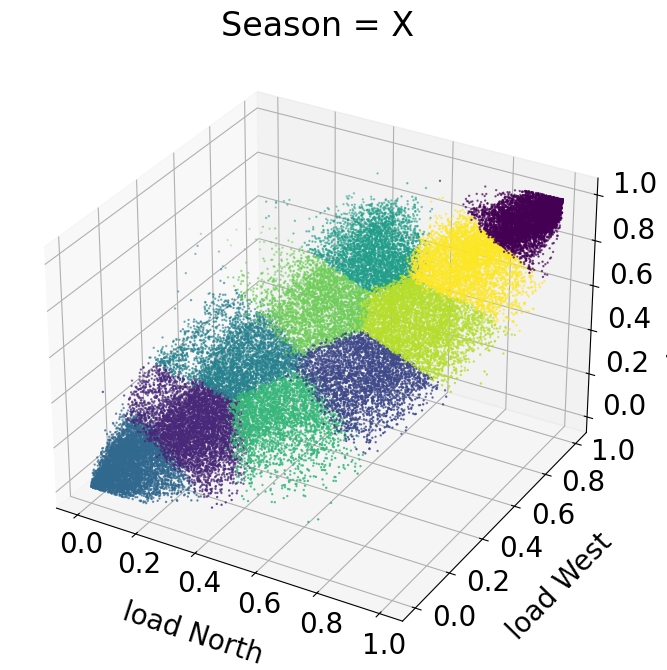

In [12]:
from sklearn.cluster import KMeans

def make_copula_cluster_3d(copula, n_cluster):
    _copula = copula.copy()
    kmeans = KMeans(init="k-means++", n_clusters=n_cluster, n_init=100)
    kmeans.fit(_copula[["rank_value_x", "rank_value_y", "rank_value_z"]])
    group = kmeans.predict(_copula[["rank_value_x", "rank_value_y", "rank_value_z"]])
    _copula.insert(len(_copula.columns), "ClusterGroup", group)

    # Create a 3D scatter plot
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs=_copula["rank_value_x"], ys=_copula["rank_value_y"], zs=_copula["rank_value_z"], c=_copula["ClusterGroup"], s=0.5)
    ax.set_xlabel(f"{DF_X} {loc_x}", labelpad=15, rotation_mode='anchor')
    ax.set_ylabel(f"{DF_Y} {loc_y}", labelpad=20, rotation_mode='anchor')
    ax.set_zlabel(f"{DF_Z} {loc_z}", labelpad=20, rotation_mode='anchor')
    ax.set_title(f"Season = X")

    # Adjust axis label positions and angles
    ax.tick_params(axis='x', pad=12)
    ax.tick_params(axis='y', pad=3)
    ax.tick_params(axis='z', pad=-1)

    ticks = ["0.0", "0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]
    ax.set_xticklabels(ticks, verticalalignment='baseline', horizontalalignment='left')
    ax.set_yticklabels(ticks, verticalalignment='baseline', horizontalalignment='left')
    ax.set_zticklabels(ticks, verticalalignment='baseline', horizontalalignment='left')

    # Rotate the entire axis label text
    # ax.view_init(elev=20, azim=30)

    plt.savefig("copula_figs/3d-cluster")
    plt.show()

make_copula_cluster_3d(copula=df_copula_original, n_cluster=10)


### 2D-clustering

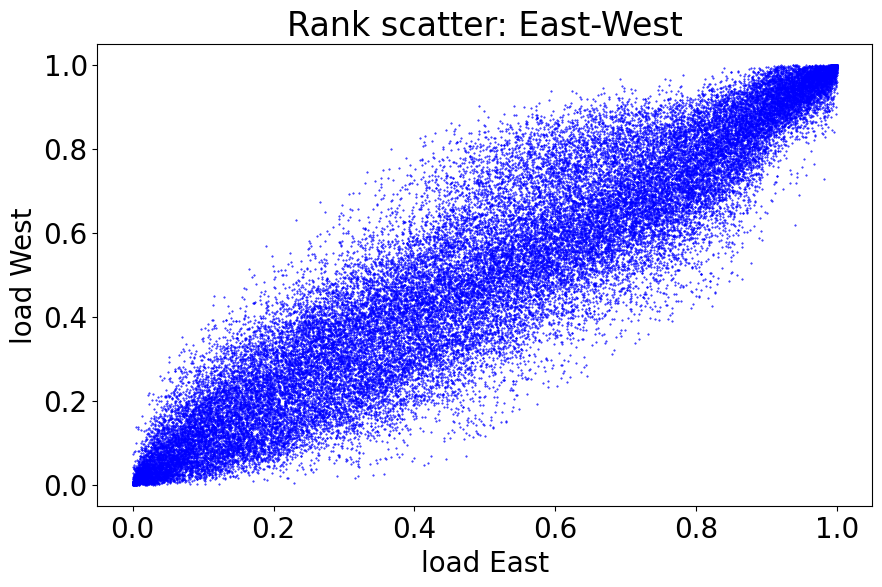

,rank_value_x,rank_value_y,rank_value_z
0,0.169131,0.495391,0.169131
1,0.114321,0.428897,0.114321
2,0.075347,0.334839,0.075347
3,0.067725,0.275260,0.067725
4,0.073795,0.257827,0.073795
...,...,...,...
43819,0.384150,0.627578,0.384150
43820,0.309351,0.502715,0.309351
43821,0.277040,0.459337,0.277040
43822,0.218488,0.446901,0.218488


In [17]:
LOCATION_X = "East"
LOCATION_Y = "West"
DF_X = "load"
DF_Y = "load"

def plot_copula_2d(df: pd.DataFrame, loc_x: str, loc_y: str) -> None:
    _df = df.copy()
    x = _df["rank_value_x"]
    y = _df["rank_value_y"]

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color="blue", s=0.2)
    plt.xlabel(f"{DF_X} {loc_x}")
    plt.ylabel(f"{DF_Y} {loc_y}")
    plt.title(f"Rank scatter: {loc_x}-{loc_y}")
    plt.show()

loc_x = LOCATION_X
loc_y = LOCATION_Y
df_x = remove_time_and_filter_location(MAPPING[DF_X], location=loc_x)
df_y = remove_time_and_filter_location(MAPPING[DF_Y], location=loc_y)


df_copula_original = generate_copula_3d(df_x, df_y, df_z, sampling_hours=None)
plot_copula_2d(df_copula_original, loc_x, loc_y)
df_copula_original

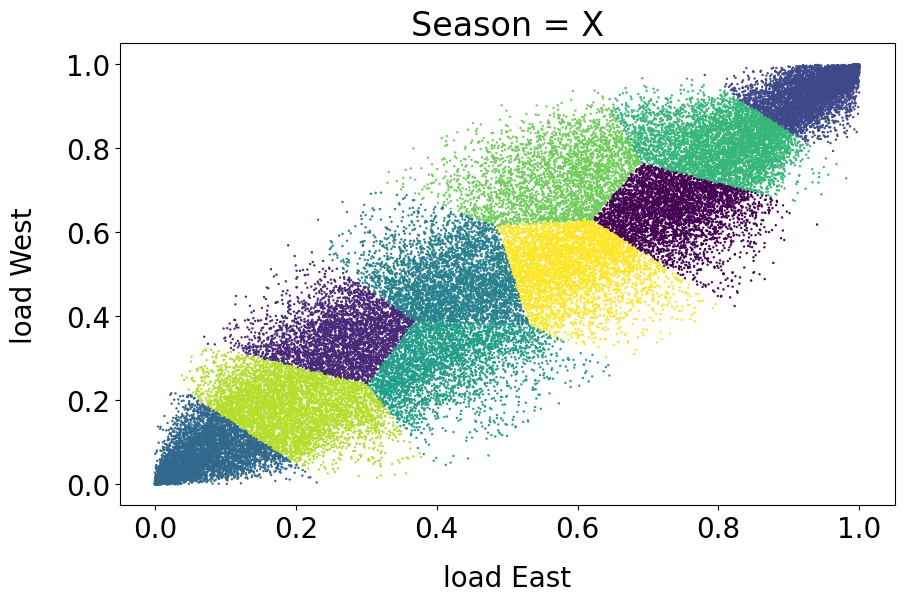

In [21]:
from sklearn.cluster import KMeans

def make_copula_cluster_2d(copula, n_cluster):
    _copula = copula.copy()
    kmeans = KMeans(init="k-means++", n_clusters=n_cluster, n_init=100)
    kmeans.fit(_copula[["rank_value_x", "rank_value_y"]])
    group = kmeans.predict(_copula[["rank_value_x", "rank_value_y"]])
    _copula.insert(len(_copula.columns), "ClusterGroup", group)

    # Create a 3D scatter plot
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(10, 6))
    plt.scatter(x=_copula["rank_value_x"], y=_copula["rank_value_y"], c=_copula["ClusterGroup"], s=0.5)
    plt.xlabel(f"{DF_X} {loc_x}", labelpad=15, rotation_mode='anchor')
    plt.ylabel(f"{DF_Y} {loc_y}", labelpad=20, rotation_mode='anchor')
    plt.title(f"Season = X")

    #plt.savefig("copula_figs/3d-cluster")
    plt.show()

make_copula_cluster_2d(copula=df_copula_original, n_cluster=10)
